In [30]:
# Netflix Data Analysis and Recommendation Project (for Resume)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os

In [31]:
# Check if WordCloud is available
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ModuleNotFoundError:
    WORDCLOUD_AVAILABLE = False

In [32]:
# Load data
zip_path = 'netflix_titles.csv.zip'
csv_path = 'netflix_titles.csv'


In [33]:
if os.path.exists(zip_path):
    import zipfile
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('netflix_dataset')
    df = pd.read_csv('netflix_dataset/netflix_titles.csv')
elif os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    raise FileNotFoundError("Netflix dataset not found. Please ensure the CSV or ZIP file is in the same directory.")


In [34]:
df['date_added'] = pd.to_datetime(df['date_added'].str.strip(), format='mixed', errors='coerce')


In [35]:
df[['duration_num', 'duration_type']] = df['duration'].dropna().str.extract(r'(\d+)\s*(\w+)')
df['duration_num'] = pd.to_numeric(df['duration_num'], errors='coerce')
df['country'].fillna('Unknown', inplace=True)
df['cast'].fillna('Not Available', inplace=True)
df['director'].fillna('Not Available', inplace=True)
df['rating'].fillna('Not Rated', inplace=True)
df['duration_type'].fillna('Unknown', inplace=True)
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

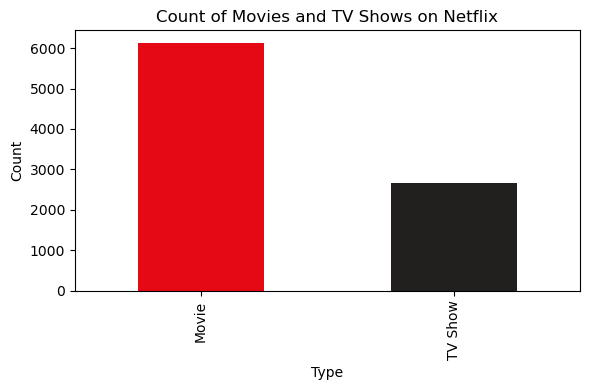

In [36]:
# --- Exploratory Data Analysis (EDA) ---
plt.figure(figsize=(6,4))
df['type'].value_counts().plot(kind='bar', color=['#E50914', '#221f1f'])
plt.title('Count of Movies and TV Shows on Netflix')
plt.xlabel('Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

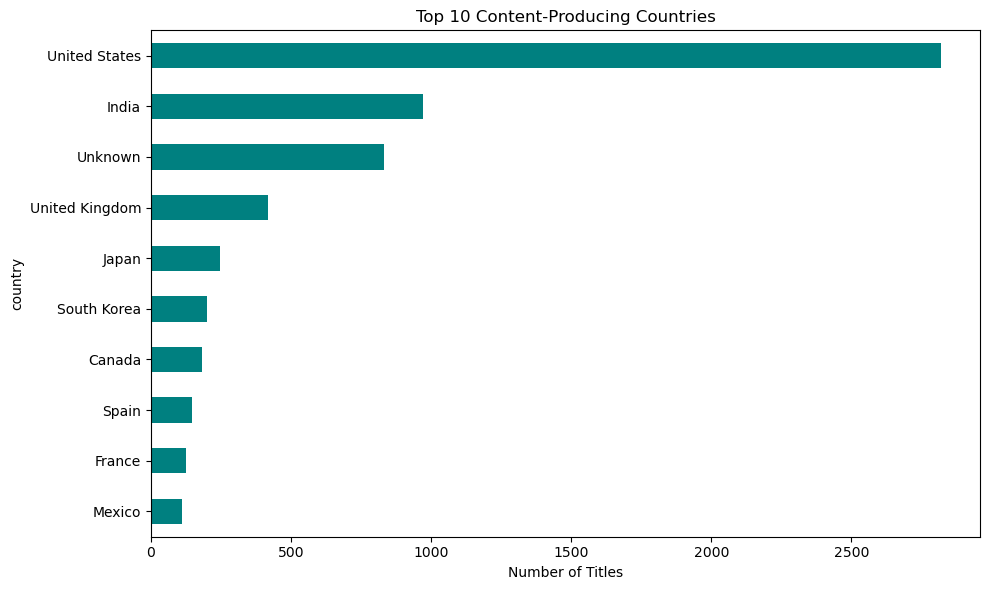

In [37]:
plt.figure(figsize=(10,6))
df['country'].value_counts().head(10).plot(kind='barh', color='teal')
plt.title('Top 10 Content-Producing Countries')
plt.xlabel('Number of Titles')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


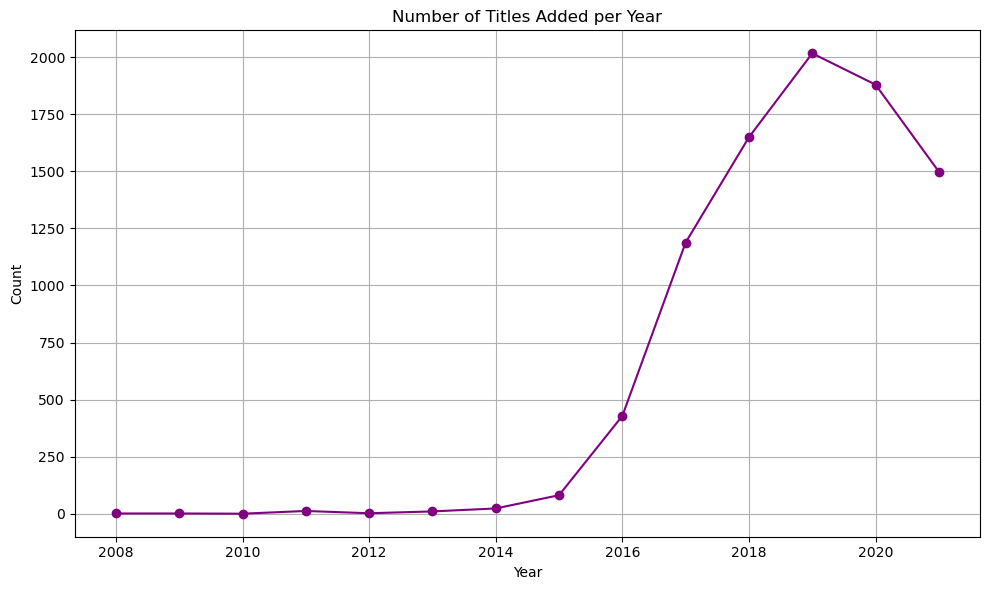

In [38]:
plt.figure(figsize=(10,6))
df['year_added'].value_counts().sort_index().plot(kind='line', marker='o', color='purple')
plt.title('Number of Titles Added per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


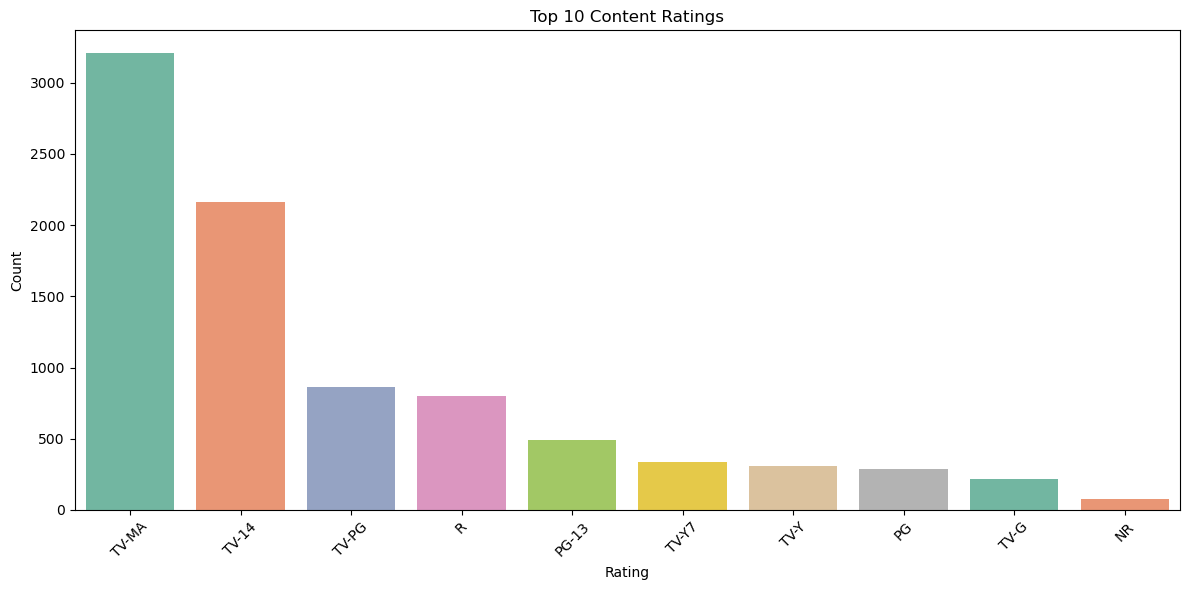

In [39]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='rating', order=df['rating'].value_counts().index[:10], palette='Set2')
plt.title('Top 10 Content Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

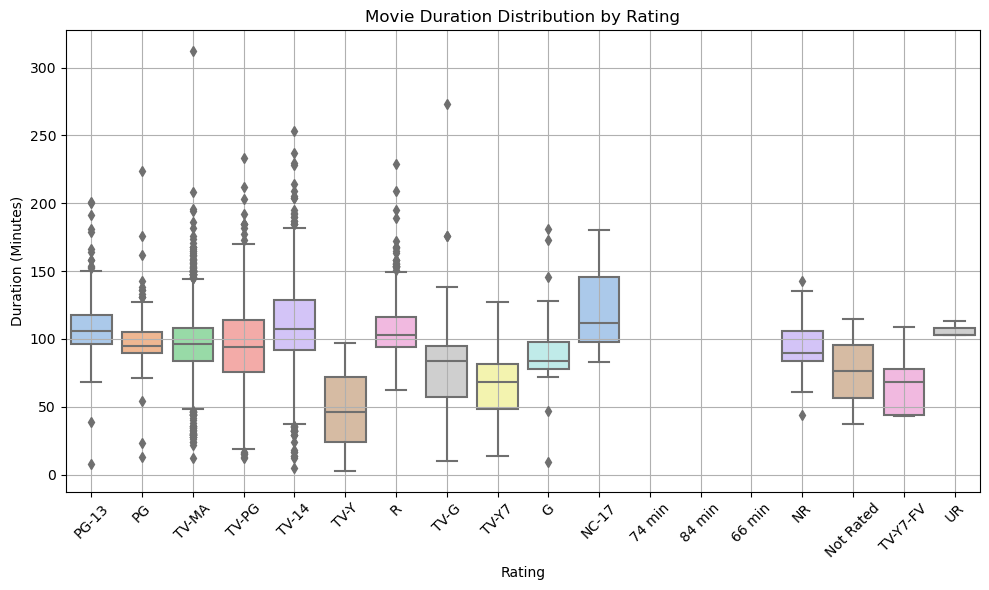

In [40]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['type'] == 'Movie'], x='rating', y='duration_num', palette='pastel')
plt.title('Movie Duration Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Duration (Minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

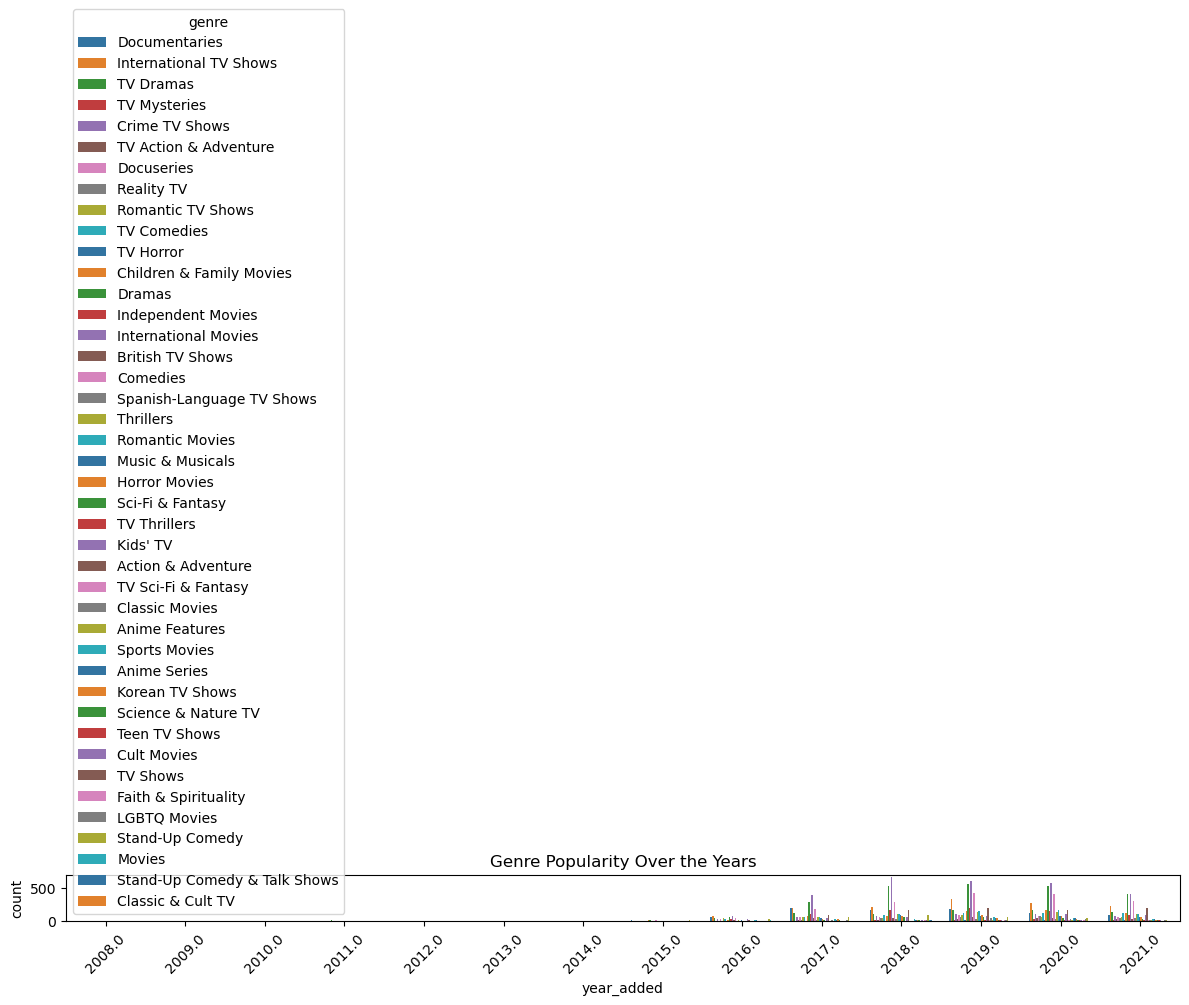

In [41]:
# --- Genre Popularity Over Time ---
genre_explode = df['listed_in'].dropna().str.split(',').explode().str.strip()
genre_year = df[['year_added']].join(genre_explode.rename('genre')).dropna()
plt.figure(figsize=(12,6))
sns.countplot(data=genre_year, x='year_added', hue='genre', order=sorted(genre_year['year_added'].dropna().unique()), palette='tab10')
plt.title('Genre Popularity Over the Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [45]:
# --- Recommendation System ---

netflix = df[['title', 'description', 'listed_in', 'cast']].dropna().copy()
netflix['text'] = netflix['description'] + ' ' + netflix['listed_in'] + ' ' + netflix['cast']

In [46]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(netflix['text'])


In [47]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(netflix.index, index=netflix['title'].str.lower()).drop_duplicates()

In [48]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices.get(title.lower())
    if idx is None:
        return ["Title not found"]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    rec_indices = [i[0] for i in sim_scores]
    return netflix['title'].iloc[rec_indices].tolist()


In [49]:
# Example
print("Recommendations for 'Narcos':")
print(get_recommendations("Narcos"))


Recommendations for 'Narcos':
['Wild District', 'El Cartel', 'El final del paraíso', 'The Great Heist', 'Dueños del paraíso']


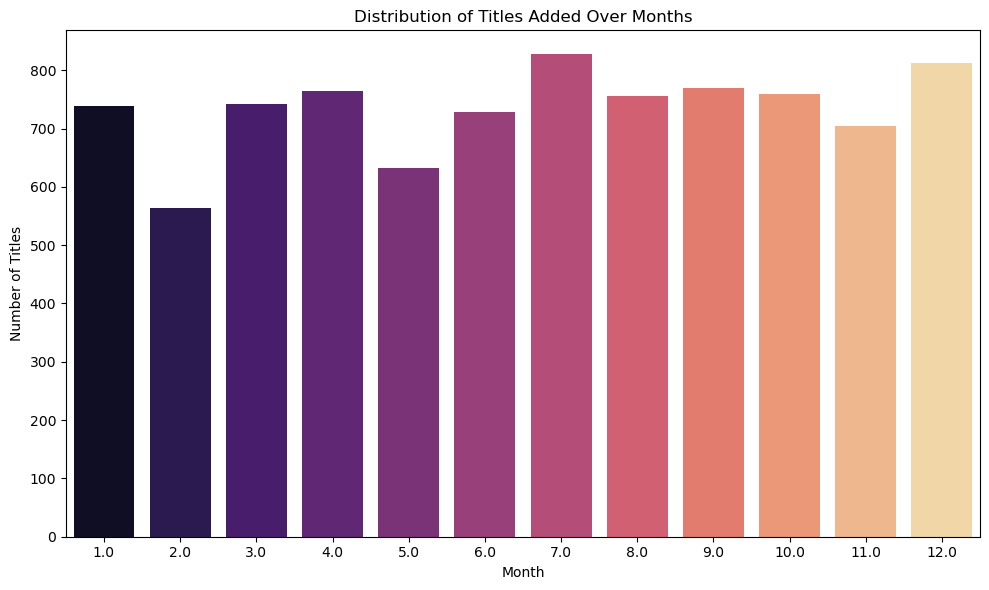

In [50]:
# --- Show Distribution Over Months ---
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='month_added', palette='magma')
plt.title('Distribution of Titles Added Over Months')
plt.xlabel('Month')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()


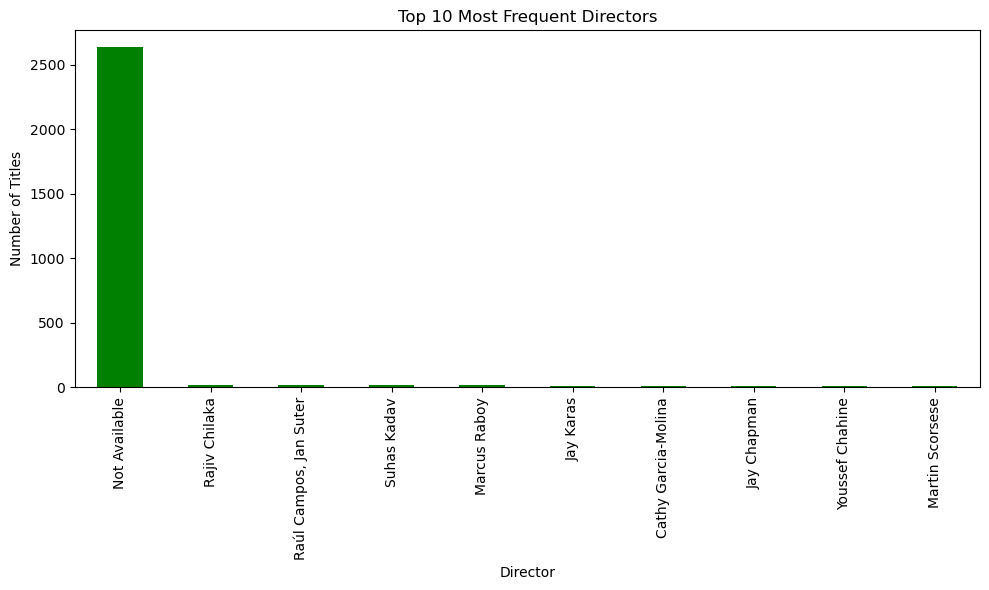

In [51]:
# --- Most Frequent Directors ---
plt.figure(figsize=(10,6))
df['director'].value_counts().head(10).plot(kind='bar', color='green')
plt.title('Top 10 Most Frequent Directors')
plt.xlabel('Director')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()

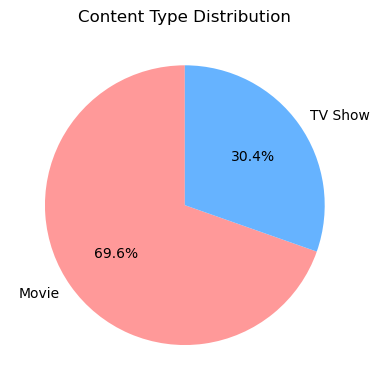

In [54]:
# --- Pie Chart: Type Distribution ---
plt.figure(figsize=(4,4))
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Content Type Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

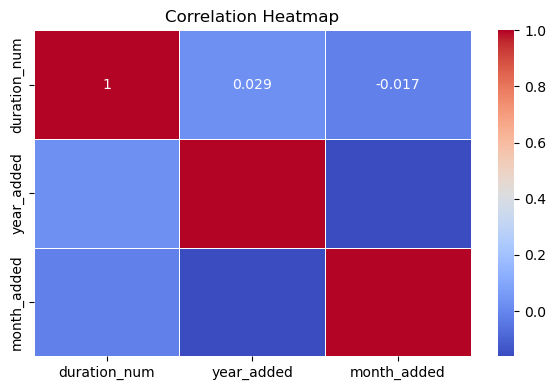

In [55]:
# --- Correlation Heatmap of Numerical Features ---
plt.figure(figsize=(6,4))
sns.heatmap(df[['duration_num', 'year_added', 'month_added']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


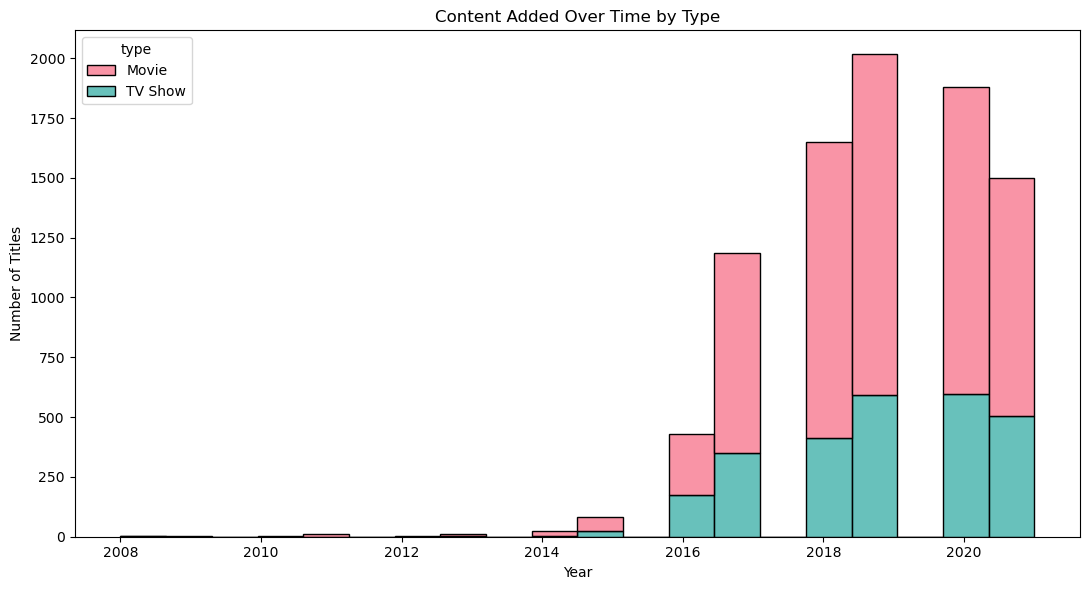

In [57]:
# --- Additional Insight: Content Added Over Time by Type ---
plt.figure(figsize=(11,6))
sns.histplot(data=df, x='year_added', hue='type', multiple='stack', palette='husl', bins=20)
plt.title('Content Added Over Time by Type')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()

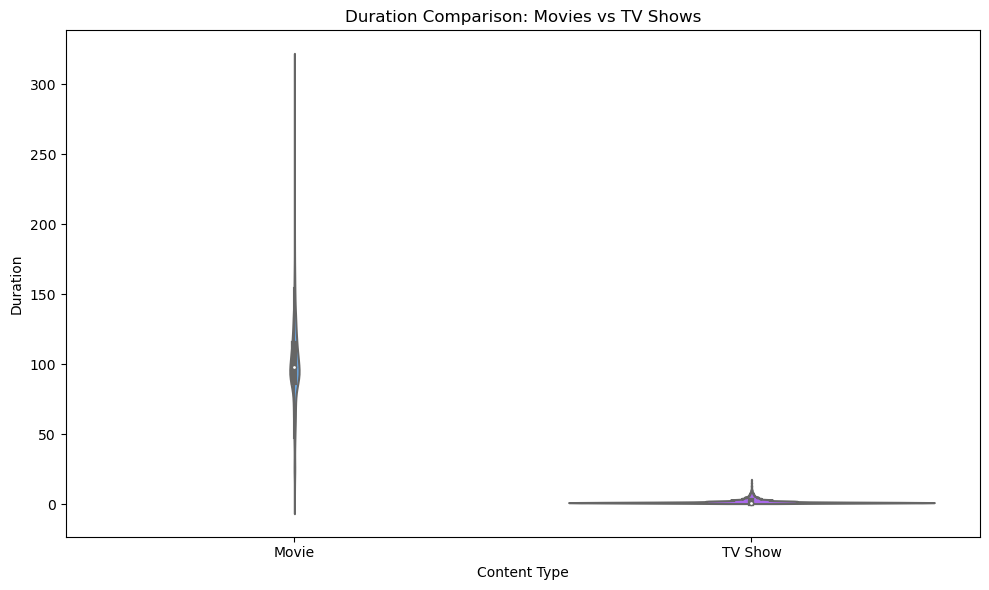

In [58]:
# --- Additional Insight: Duration Comparison Between Movies and Shows ---
plt.figure(figsize=(10,6))
sns.violinplot(data=df, x='type', y='duration_num', palette='cool')
plt.title('Duration Comparison: Movies vs TV Shows')
plt.xlabel('Content Type')
plt.ylabel('Duration')
plt.tight_layout()
plt.show()

In [59]:
# --- Additional Insight: Frequent Keywords in Titles ---
from collections import Counter


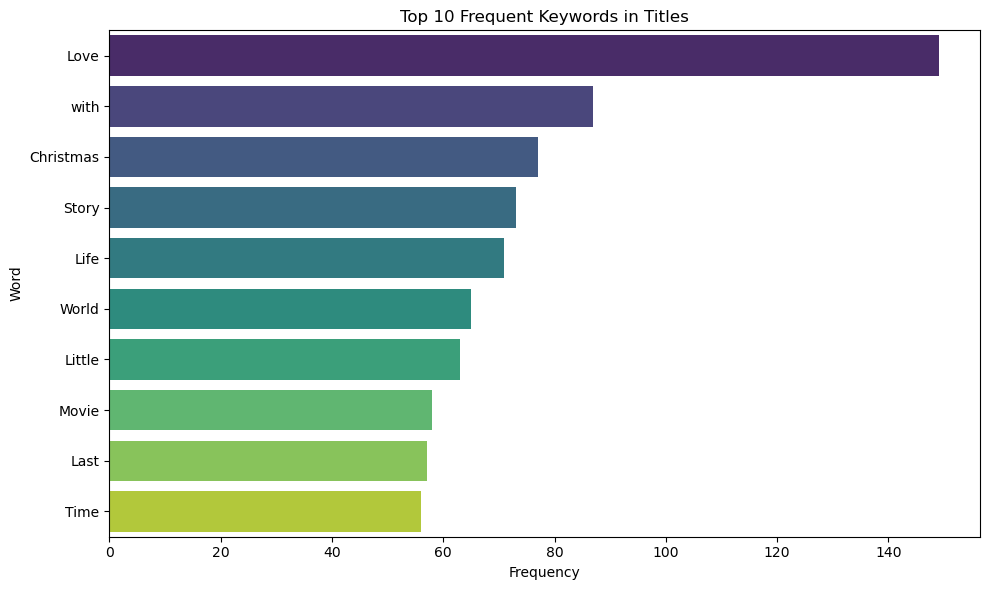

In [60]:
keywords = ' '.join(df['title'].dropna()).split()
common_words = Counter([word for word in keywords if len(word) > 3])
common_df = pd.DataFrame(common_words.most_common(10), columns=['Word', 'Frequency'])
plt.figure(figsize=(10,6))
sns.barplot(data=common_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 10 Frequent Keywords in Titles')
plt.tight_layout()
plt.show()

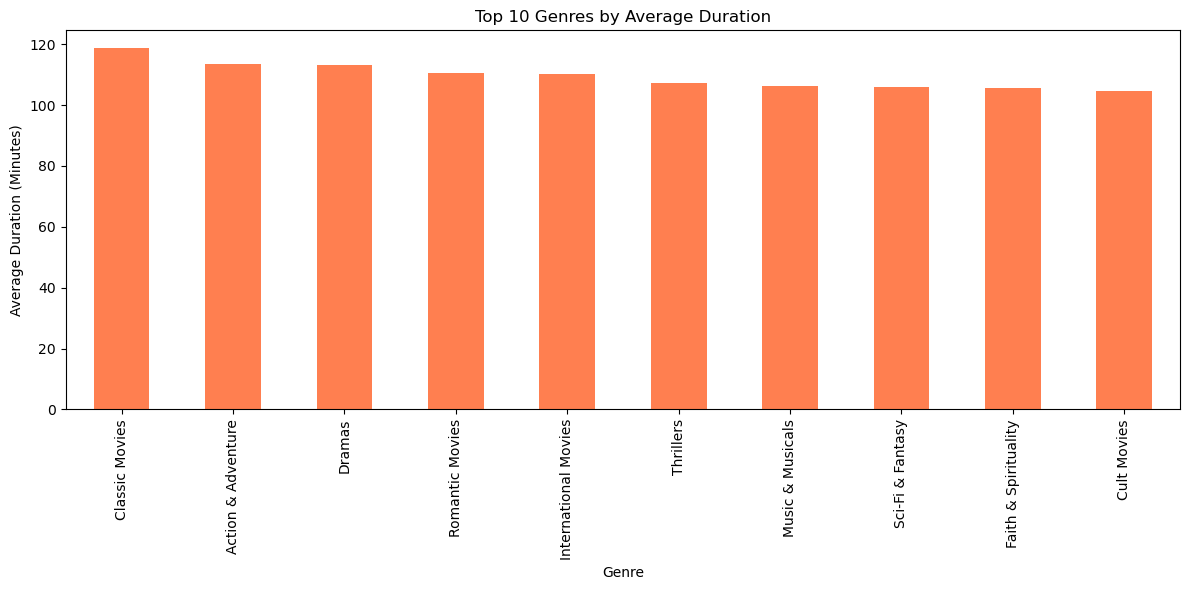

In [61]:
# --- Additional Insight: Average Duration per Genre ---
df_genre_duration = df.dropna(subset=['listed_in', 'duration_num'])
df_genre_duration = df_genre_duration.assign(genre=df_genre_duration['listed_in'].str.split(',')).explode('genre')
df_genre_duration['genre'] = df_genre_duration['genre'].str.strip()
avg_duration = df_genre_duration.groupby('genre')['duration_num'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
avg_duration.plot(kind='bar', color='coral')
plt.title('Top 10 Genres by Average Duration')
plt.xlabel('Genre')
plt.ylabel('Average Duration (Minutes)')
plt.tight_layout()
plt.show()
